## Dissecting the data for "Suppressing quantum errors by scaling a surface code logical qubit"

In this experiment, the Google team demonstrated how scaling up the surface code does result in better error correction, rather than worsening the overall performance by introducing new error sources.

This is the dataset that PyMatching is benchmarched against, and it will be useful to do that as well in this project.

Most of the information reported here comes mainly from the `README.MD` of this dataset, as well as Stim's __[docs](https://github.com/quantumlib/Stim/tree/main/doc)__.

In [1]:
import os
import re
import yaml
from typing import List, Union

import stim
import numpy as np

from IPython.display import SVG, display

### __Main utility vars and functions__

Various variables and methods that will be referenced later in the notebook.

In [2]:
# main directory of the dataset
current_dir = os.getcwd()
dataset = "google_qec3v5_experiment_data"

googleds_dir = os.path.join(current_dir, "..", "datasets", dataset) ## assuming ds is in sibling dir of the current one
googleds_dir

'd:\\salva\\Documents\\qec-fpga_dir\\tests\\..\\datasets\\google_qec3v5_experiment_data'

In [3]:
def display_dir_content(dirpath: str) -> None:
    """
    Displays the contents of a directory.

    Args:
        dirpath: Path to the directory.
    """
    print(f"Contents of {dirpath}:")
    for _, _, files in os.walk(dirpath):
        for file in files:
            print(f" - {file}")

---

#### The `b8` format

Measurements, detection events and sweep configurations are stored in the `b8` format (see docs). Here, it follows some sample code to parse and store files in this extension (also from the docs).

In [4]:
def parse_b8(data: bytes, bits_per_shot: int) -> List[List[bool]]:
    shots = []
    bytes_per_shot = (bits_per_shot + 7) // 8
    for offset in range(0, len(data), bytes_per_shot):
        shot = []
        for k in range(bits_per_shot):
            byte = data[offset + k // 8]
            bit = (byte >> (k % 8)) % 2 == 1
            shot.append(bit)
        shots.append(shot)
    return shots

In [5]:
def save_b8(shots: List[List[bool]]) -> bytes:
    output = b""
    for shot in shots:
        bytes_per_shot = (len(shot) + 7) // 8
        v = 0
        for b in reversed(shot):
            v <<= 1
            v += int(b)
        output += v.to_bytes(bytes_per_shot, 'little')
    return output

#### The `01` format

The 01 format is a dense human readable format that stores shots as lines of '0' and '1' characters.

The data from each shot is terminated by a newline character '\n'. Each character in the line is a '0' (indicating False) or a '1' (indicating True) corresponding to a measurement result (or a detector result) from a circuit.

Similarly as before, parsing and saving code is provided.

In [6]:
def parse_01(data: str) -> List[List[bool]]:
    shots = []
    for line in data.split('\n'):
        if not line:
            continue
        shot = []
        for c in line:
            assert c in '01'
            shot.append(c == '1')
        shots.append(shot)
    return shots

In [7]:
def save_01(shots: List[List[bool]]) -> str:
    output = ""
    for shot in shots:
        for sample in shot:
            output += '1' if sample else '0'
        output += "\n"
    return output

### __Generic dataset stats__

Here, we see how the main parameters are distributed in the dataset, which will turn useful to understand how to perform tests on the final model.

From this point on, the single subdirectory that refers to a repetition code experiment will not be considered, as we are only interested in those related to surface codes.

In [8]:
print(f"Dataset has {len(next(os.walk(googleds_dir))[1]) - 1} total experiments.")

Dataset has 130 total experiments.


It may also be useful to see how many of those experiments are about `X` and `Z` memory, as well as how many of them have been done on distance 3 and 5 codes:

In [9]:
basis_counts = {"X": 0, "Z": 0}
distance_counts = {3: 0, 5: 0}

# from the docs: each subdirectory's name follows the pattern
#   {code}_b{basis}_d{distance}_r{rounds}_center_{row}_{col}
#
pattern = re.compile(r"surface_code_b(?P<basis>[XZ])_d(?P<distance>\d+)_.*")

# main loop through all subdirectories' names as all of the 
# required info is in the filenames and there is no need of
# going down the dirtree
#
for subdir in os.listdir(googleds_dir):
    subdir_path = os.path.join(googleds_dir, subdir)

    if os.path.isdir(subdir_path):
        match = pattern.match(subdir)

        if match:
            basis = match.group("basis")
            distance = int(match.group("distance"))

            if basis in basis_counts:
                basis_counts[basis] += 1
            if distance in distance_counts:
                distance_counts[distance] += 1

print(f"Basis counts: {basis_counts}\nDistance counts: {distance_counts}")

Basis counts: {'X': 65, 'Z': 65}
Distance counts: {3: 104, 5: 26}


### __Contents and file formats__
All of the main info about data and formats can be found in the `README.MD` file.

For the rest of the notebook, we will analyze two reference experiments:
- the first one, as it is smaller and easier to deconstruct;
- the last one, that embeds some generalized considerations needed to process the entire dataset.

In [10]:
# reference dirs for the two experiments
first_exp_dir = os.path.join(googleds_dir, "surface_code_bX_d3_r01_center_3_5")
last_exp_dir = os.path.join(googleds_dir, "surface_code_bZ_d5_r25_center_5_5")

In [11]:
display_dir_content(first_exp_dir) # structure is the same for the last exp and any other one

Contents of d:\salva\Documents\qec-fpga_dir\tests\..\datasets\google_qec3v5_experiment_data\surface_code_bX_d3_r01_center_3_5:
 - circuit_detector_error_model.dem
 - circuit_ideal.stim
 - circuit_noisy.stim
 - detection_events.b8
 - layout.svg
 - measurements.b8
 - obs_flips_actual.01
 - obs_flips_predicted_by_belief_matching.01
 - obs_flips_predicted_by_correlated_matching.01
 - obs_flips_predicted_by_pymatching.01
 - obs_flips_predicted_by_tensor_network_contraction.01
 - pij_from_even_for_odd.dem
 - pij_from_odd_for_even.dem
 - properties.yml
 - sweep.b8


It will be useful to define a Class that models individual experiments, so that its contents can be more easily accessed in the future:

In [12]:
class Experiment:

    def __init__(
            self,
            directory: str
        ):
        """
        Initialize an Experiment object by dynamically creating attributes
        for each file in the given directory.

        Args:
            directory: path to the experiment directory.
        """
        self.directory = directory

        # parsing properties of the experiment separately
        with open(os.path.join(directory, "properties.yml")) as stream:
            self.properties = yaml.safe_load(stream)

        # properties.yml no longer needs to be involved
        dirlist = os.listdir(directory)
        dirlist.remove("properties.yml")

        # extract the remaining files
        for file in dirlist:
            file_path = os.path.join(directory, file)

            if os.path.isfile(file_path):
                filename, extension = os.path.splitext(file)
                attr_dict = {"path": file_path, "extension": extension}

                # create an attribute with the filename (without extension) 
                # as the name and a dict with full path and extension 
                # as the value 
                setattr(self, filename, attr_dict)

    def parse_content(
            self,
            attr_name: str
        ) -> Union[stim.DetectorErrorModel, stim.Circuit, List[List[bool]], SVG]:
        """
        Retrieves the contents of the specified attribute by parsing the 
        associated file.

        After parsing, the value of the attribute is replaced with the data itself
        to avoid the need for future parsing.

        Args:
            attr_name: filename (without extension) to parse.

        Returns:
            Parsed content of the file associated with the attribute.
        """
        
        # get reference data
        attr_dict = getattr(self, attr_name)

        # this is in the case one calls parse_content() twice on the same attribute
        if not isinstance(attr_dict, dict):
            return attr_dict

        path, extension = attr_dict["path"], attr_dict["extension"]

        # parse according to extension
        if extension == ".dem":
            attr_content = stim.DetectorErrorModel.from_file(path)
        elif extension == ".stim":
            attr_content = stim.Circuit.from_file(path)
        elif extension == ".b8":
            # map for the bits_per_shot parameter derived from the README.md
            b8_bps_map = {
                "measurements": "circuit_measurements",
                "detection_events": "circuit_detectors",
                "sweep": "circuit_sweep_bits"
                }
            with open(path, "rb") as stream:
                b8_data = stream.read()
            attr_content = parse_b8(data=b8_data, bits_per_shot=self.properties[b8_bps_map[attr_name]])
        elif extension == ".01":
            with open(path, "r") as stream:
                data = stream.read()
            attr_content = parse_01(data=data)
        elif extension == ".svg":
            attr_content = SVG(filename=path)
            
        # re-setting the attribute value as the actual parsed content
        # to avoid re-parsing it every time
        setattr(self, attr_name, attr_content)

        return attr_content

    def __del__(self):
        """
        Destructor for the Experiment class. Cleans up the object by deleting
        all attributes that were dynamically created.

        This will be relevant when processing the entire dataset at once, as it frees up memory
        as experiments are processed.
        """
        print(f"Destroyed object for experiment {os.path.basename(os.path.normpath(self.directory))}.")


We can then instantiate two separate objects for the two experiments and directly reference their attributes.

In [13]:
firstexp, lastexp = Experiment(first_exp_dir), Experiment(last_exp_dir)

---

#### properties.yml

The experiments have the following properties:

In [14]:
firstexp.properties

{'type': 'surface_code_memory_experiment',
 'basis': 'X',
 'rounds': 1,
 'distance': 3,
 'data_qubits': 9,
 'measure_qubits': 8,
 'shots': 50000,
 'center_data_qubit_row': 3,
 'center_data_qubit_col': 5,
 'circuit_measurements': 17,
 'circuit_sweep_bits': 9,
 'circuit_detectors': 8,
 'circuit_observables': 1,
 'circuit_qubits': 17}

In [15]:
lastexp.properties

{'type': 'surface_code_memory_experiment',
 'basis': 'Z',
 'rounds': 25,
 'distance': 5,
 'data_qubits': 25,
 'measure_qubits': 24,
 'shots': 50000,
 'center_data_qubit_row': 5,
 'center_data_qubit_col': 5,
 'circuit_measurements': 625,
 'circuit_sweep_bits': 25,
 'circuit_detectors': 600,
 'circuit_observables': 1,
 'circuit_qubits': 49}

Recall that a $d$ distance surface code needs a total of $2d^2 - 1$ qubits divided as:
- $d^2$ data qubits
- $d^2 - 1$ stabilizers

meaning that, in a $d=3$ code, there are `9` data qubits and `8` measure qubits for a total of `17`. Similarly, for $d=5$, we have a `25` + `24` = `49` full qubit count. This corresponds to what is shown in `properties.yml`.
 

---

#### layout.svg

Experiments can be visualized by the surface code diagram and the circuit that implements that logic.

Specifically, from the docs:

```
layout.svg:
    A diagram of the stabilizers and observables defining the experiment, as
    well as their relative position on the chip.
    
    Black squares are four body X stabilizers.
    Red squares are four body Z stabilizers.
    Black semicircles are two body X stabilizers.
    Red semicircles are two body Z stabilizers.
    Zig zag arrows indicate the order of operations within a stabilizer.
    Yellow circles indicate "pauses" where the order of operations waits a layer.
    Coordinate annotations indicate the positions of the qubits on the chip.
    X/Z annotations indicate the location of the logical observable being tested.
```

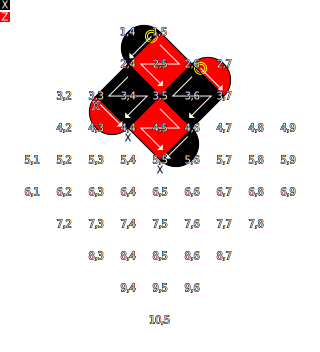

In [16]:
display(firstexp.parse_content("layout"))

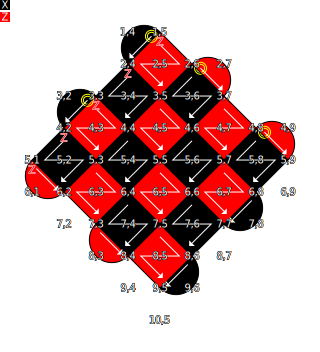

In [17]:
display(lastexp.parse_content("layout"))

Note that this this layout and coordinate systems refers to an __unrotated__ surface code. When using `stim.Circuit.generated()` for sampling __rotated__ surface code circuits, the coordinates remain the same, but they appear into a __[zig-zag pattern](https://quantumcomputing.stackexchange.com/questions/31782/simulating-the-surface-code-with-stim-meaning-of-qubit-coordinates)__ in the rotated frame of reference. This consideration may or may not be relevant, as coordinates are dummy variables and do not matter in decoding scenarios, except for plotting reasons.

---

#### Circuits and Detector Error Models

The authors provide both ideal and noisy Stim circuit models that correspond to those run on real hardware.

Specifically:

```
circuit_ideal.stim:
    The circuit that was sampled from, including annotations describing how detection events are computed and what the logical observable is. The circuit is needed in order to convert measurement data and sweep data into detection event data and observable flip data.
```

In [18]:
firstexp.parse_content("circuit_ideal")

stim.Circuit('''
    QUBIT_COORDS(1, 4) 0
    QUBIT_COORDS(1, 5) 1
    QUBIT_COORDS(2, 4) 2
    QUBIT_COORDS(2, 5) 3
    QUBIT_COORDS(2, 6) 4
    QUBIT_COORDS(2, 7) 5
    QUBIT_COORDS(3, 3) 6
    QUBIT_COORDS(3, 4) 7
    QUBIT_COORDS(3, 5) 8
    QUBIT_COORDS(3, 6) 9
    QUBIT_COORDS(3, 7) 10
    QUBIT_COORDS(4, 3) 11
    QUBIT_COORDS(4, 4) 12
    QUBIT_COORDS(4, 5) 13
    QUBIT_COORDS(4, 6) 14
    QUBIT_COORDS(5, 5) 15
    QUBIT_COORDS(5, 6) 16
    CX sweep[0] 1 sweep[1] 2 sweep[2] 4 sweep[3] 6 sweep[4] 8 sweep[5] 10 sweep[6] 12 sweep[7] 14 sweep[8] 15
    TICK
    H 3 16 0 5 11 7 9 13 8 10 15 1 6
    TICK
    CZ 11 6 3 1 9 4 7 2 13 8 16 14
    TICK
    H 12 8 14 10 15 2 1 4 6
    X 3 16 0 5 11 7 9 13
    TICK
    CZ 3 4 7 6 16 15 9 8 13 14 11 12
    TICK
    X 3 12 8 14 16 0 5 10 11 7 9 15 13 2 1 4 6
    TICK
    CZ 9 10 13 12 5 4 7 8 3 2 0 1
    TICK
    H 12 8 14 10 15 2 1 4 6
    X 3 16 0 5 11 7 9 13
    TICK
    CZ 7 12 3 8 0 2 13 15 9 14 5 10
    TICK
    H 3 16 0 5 11 7 9 13 8 1

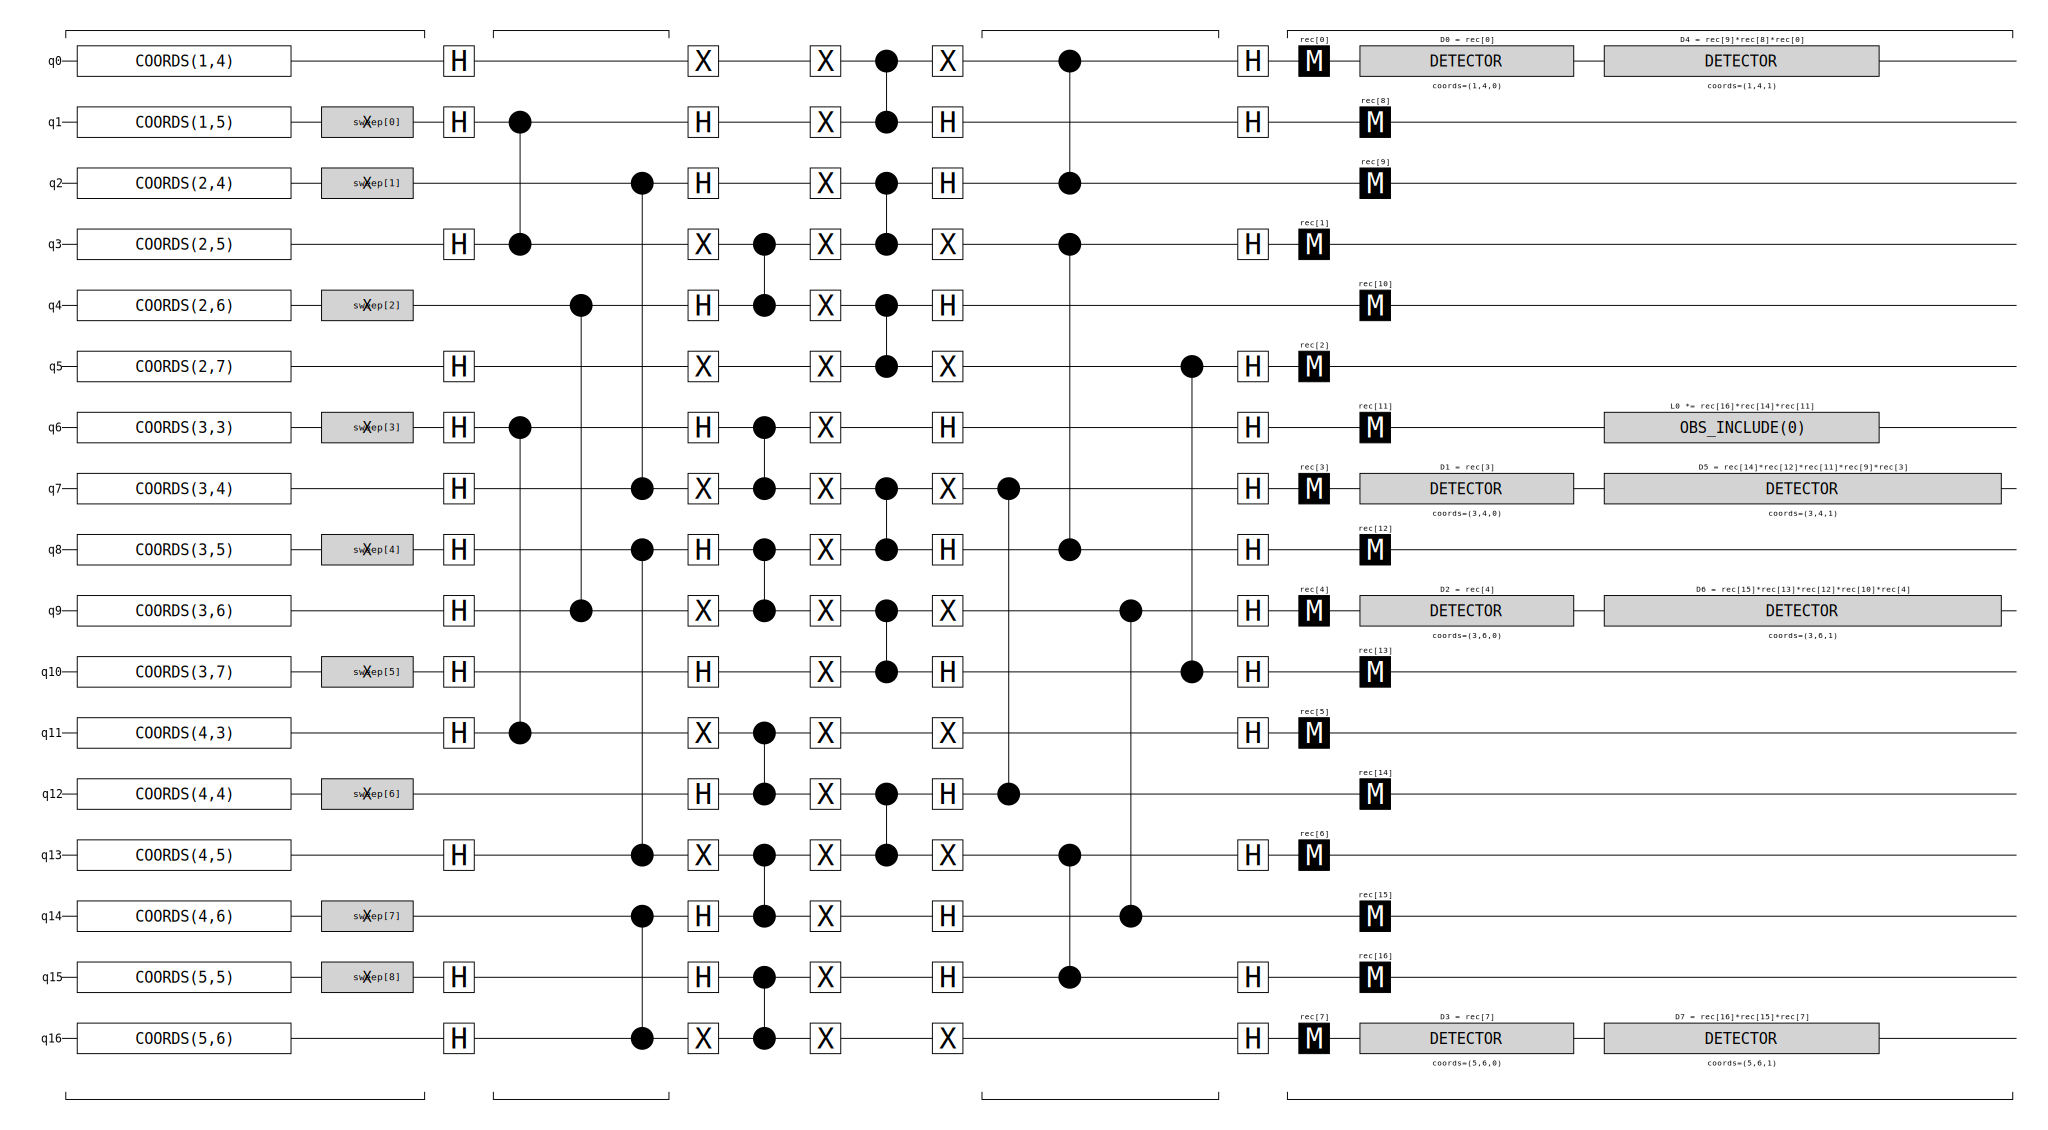

In [19]:
# circuit_ideal was already parsed, we can just call the attribute
firstexp.circuit_ideal.diagram('timeline-svg')

Similarly, there is:

```
circuit_noisy.stim:
    Same as circuit_ideal.stim, except noise annotations have been added to the
    circuit. The noise annotations implement a Pauli noise model that
    approximates the noise which occurs on hardware.
```



In [20]:
firstexp.parse_content("circuit_noisy")

stim.Circuit('''
    QUBIT_COORDS(1, 4) 0
    QUBIT_COORDS(1, 5) 1
    QUBIT_COORDS(2, 4) 2
    QUBIT_COORDS(2, 5) 3
    QUBIT_COORDS(2, 6) 4
    QUBIT_COORDS(2, 7) 5
    QUBIT_COORDS(3, 3) 6
    QUBIT_COORDS(3, 4) 7
    QUBIT_COORDS(3, 5) 8
    QUBIT_COORDS(3, 6) 9
    QUBIT_COORDS(3, 7) 10
    QUBIT_COORDS(4, 3) 11
    QUBIT_COORDS(4, 4) 12
    QUBIT_COORDS(4, 5) 13
    QUBIT_COORDS(4, 6) 14
    QUBIT_COORDS(5, 5) 15
    QUBIT_COORDS(5, 6) 16
    CX sweep[0] 1 sweep[1] 2 sweep[2] 4 sweep[3] 6 sweep[4] 8 sweep[5] 10 sweep[6] 12 sweep[7] 14 sweep[8] 15
    I 7 11 9 13 0 3 16 5
    TICK
    DEPOLARIZE1(0.00126937) 1
    DEPOLARIZE1(0.000489395) 2
    DEPOLARIZE1(0.000631499) 4
    DEPOLARIZE1(0.000643401) 6
    DEPOLARIZE1(0.00103939) 8
    DEPOLARIZE1(0.00159105) 10
    DEPOLARIZE1(0.00118143) 12
    DEPOLARIZE1(0.00220941) 14
    DEPOLARIZE1(0.0016446) 15
    DEPOLARIZE1(0.000630728) 7
    DEPOLARIZE1(0.000740408) 11
    DEPOLARIZE1(0.000634265) 9
    DEPOLARIZE1(0.000645593) 13
    D

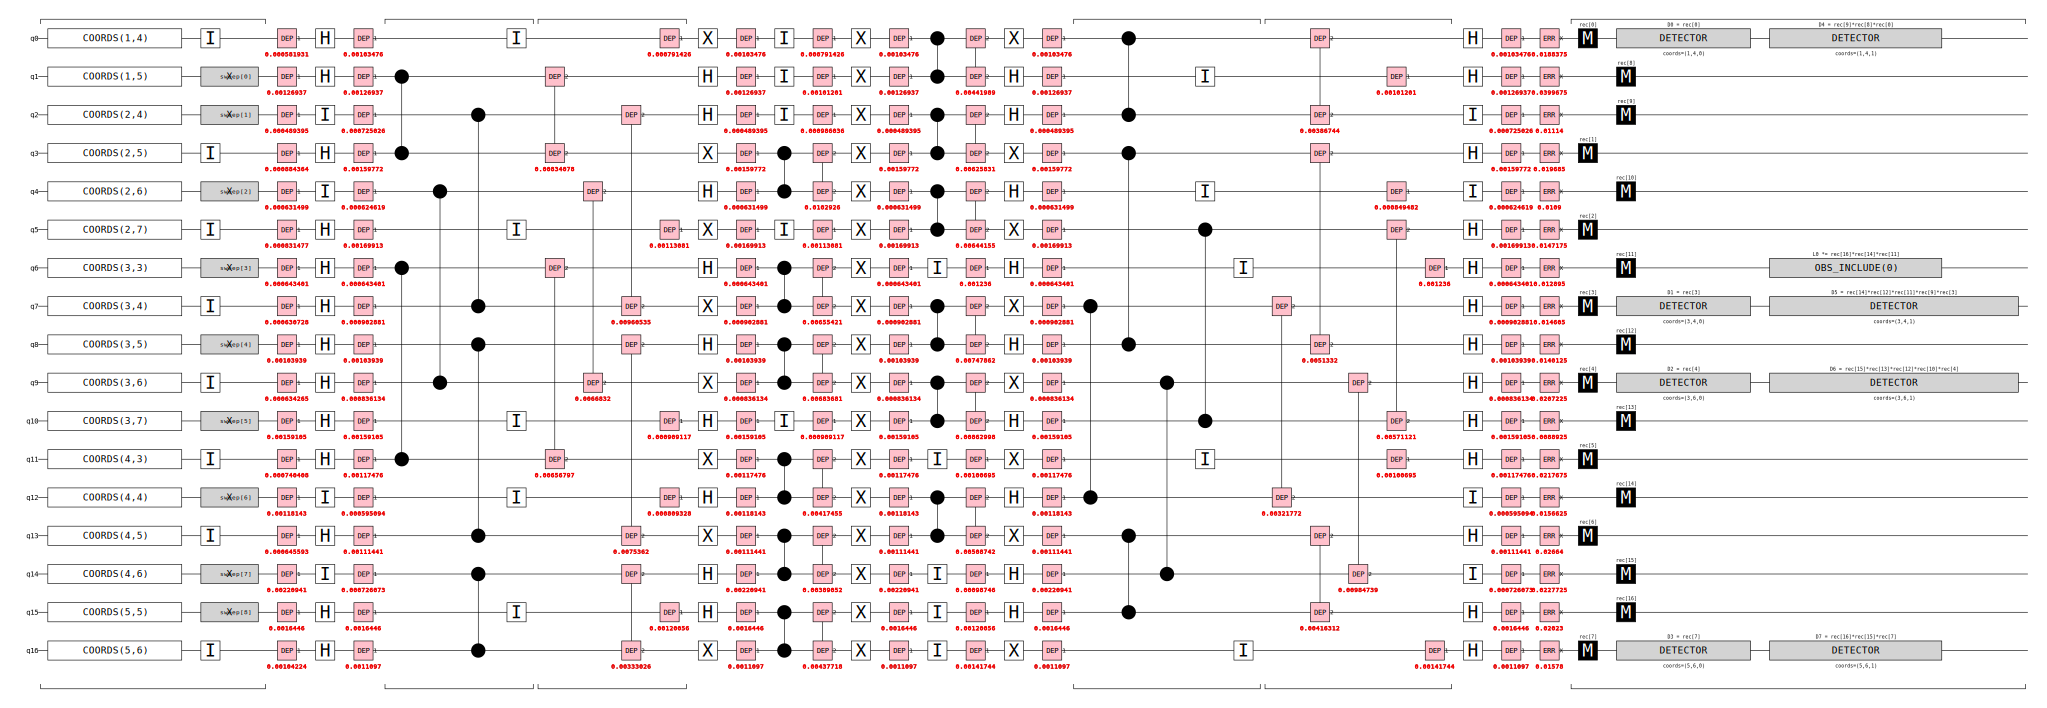

In [21]:
firstexp.circuit_noisy.diagram('timeline-svg')

We avoid plotting the $d=5$ experiments as it may get too cluttered, especially because more error-correction rounds are applied, resulting in relatively deep circuits that are difficult to visualize.

Also, from now on, only the realistic, noise-modeled circuits will be of relevance.

The detector error model for the examples can either be parsed from the dataset or re-generated by Stim. Of course, in either cases, the results are equivalent:

In [22]:
# stim.DetectorErrorModel.approx_equals(other, atol) allows to compare two DEMs and 
# check if they are equivalent up to a tolerance amount atol in the error proabilities
#
firstexp.parse_content("circuit_detector_error_model")\
    .approx_equals(firstexp.circuit_noisy.detector_error_model(decompose_errors=True), atol=0.001)

True

In general, we will use pre-computed DEMs, since they are (a) faster to retrieve and (b) the above comparison with one generated with the `decompose_errors=True` parameter suggests that they are also graphlike, which is what we need for the subsequent decoding tasks.

In [23]:
lastexp.parse_content("circuit_noisy")
lastexp.parse_content("circuit_detector_error_model");

It is also interesting to display the associated detector graphs, as those are in the form that decoding will be performed on:

In [24]:
firstexp.circuit_detector_error_model.diagram("matchgraph-3d")

{"accessors":[{"bufferView":0,"byteOffset":0,"componentType":5126,"count":9,"max":[0,0.400000005960464,0.400000005960464],"min":[0,-0.400000005960464,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":1,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0,0.400000005960464],"min":[-0.400000005960464,0,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":2,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0.400000005960464,0],"min":[-0.400000005960464,-0.400000005960464,0],"name":"circle_loop","type":"VEC3"},{"bufferView":3,"byteOffset":0,"componentType":5126,"count":9,"max":[0,0.400000005960464,0.400000005960464],"min":[0,-0.400000005960464,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":4,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0,0.400000005960464],"min":[-0.400000005960464,0,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":5,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0.400000005960464,0],"min":[-0.400000005960464,-0.400000005960464,0],"name":"circle_loop","type":"VEC3"},{"bufferView":6,"byteOffset":0,"componentType":5126,"count":50,"max":[15,26.9442710876465,7.4721360206604],"min":[-5.72871494293213,7.63564252853394,-4.4721360206604],"name":"buf_scattered_lines","type":"VEC3"},{"bufferView":7,"byteOffset":0,"componentType":5126,"count":20,"max":[23.7287139892578,22.3643569946289,7.4721360206604],"min":[9,3.0557279586792,-4.4721360206604],"name":"buf_red_scattered_lines","type":"VEC3"}],"asset":{"version":"2.0"},"bufferViews":[{"buffer":0,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":1,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":2,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":3,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":4,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":5,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":6,"byteLength":600,"byteOffset":0,"name":"buf_scattered_lines","target":34962},{"buffer":7,"byteLength":240,"byteOffset":0,"name":"buf_red_scattered_lines","target":34962}],"buffers":[{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAM3MzD4AAAAAAAAAAMPQkD7D0JA+AAAAAPIwlrLNzMw+AAAAAMPQkL7D0JA+AAAAAM3MzL7yMBazAAAAAMHQkL7E0JC+AAAAAPLkozHNzMy+AAAAAMbQkD6/0JC+AAAAAM3MzD4AAAAA"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAAAAAADNzMw+w9CQPgAAAADD0JA+zczMPgAAAADyMJayw9CQPgAAAADD0JC+8jAWswAAAADNzMy+xNCQvgAAAADB0JC+zczMvgAAAADy5KMxv9CQvgAAAADG0JA+AAAAAAAAAADNzMw+"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,zczMPgAAAAAAAAAAw9CQPsPQkD4AAAAA8jCWss3MzD4AAAAAw9CQvsPQkD4AAAAAzczMvvIwFrMAAAAAwdCQvsTQkL4AAAAA8uSjMc3MzL4AAAAAxtCQPr/QkL4AAAAAzczMPgAAAAAAAAAA"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAM3MzD4AAAAAAAAAAMPQkD7D0JA+AAAAAPIwlrLNzMw+AAAAAMPQkL7D0JA+AAAAAM3MzL7yMBazAAAAAMHQkL7E0JC+AAAAAPLkozHNzMy+AAAAAMbQkD6/0JC+AAAAAM3MzD4AAAAA"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAAAAAADNzMw+w9CQPgAAAADD0JA+zczMPgAAAADyMJayw9CQPgAAAADD0JC+8jAWswAAAADNzMy+xNCQvgAAAADB0JC+zczMvgAAAADy5KMxv9CQvgAAAADG0JA+AAAAAAAAAADNzMw+"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,zczMPgAAAAAAAAAAw9CQPsPQkD4AAAAA8jCWss3MzD4AAAAAw9CQvsPQkD4AAAAAzczMvvIwFrMAAAAAwdCQvsTQkL4AAAAA8uSjMc3MzL4AAAAAxtCQPr/QkL4AAAAAzczMPgAAAAAAAAAA"},{"byteLength":600,"name":"buf_scattered_lines","uri":"data:application/octet-stream;base64,AABAQAAAQEEAAAAAolG3wC9X9EDRqAvAAABAQAAAQEEAAAAAAAAQQQAAQEEAAAAAAABAQAAAQEEAAAAAAABAQAAAQEEAAEBAAABAQAAAQEEAAAAAAAAQQQAAQEEAAEBAAABAQAAAQEEAAAAAAAAQQQAAkEEAAEBAAAAQQQAAQEEAAAAAAAAQQQAAkEEAAAAAAAAQQQAAQEEAAAAAAAAQQQAAQE

In [25]:
lastexp.circuit_detector_error_model.diagram("matchgraph-3d")

{"accessors":[{"bufferView":0,"byteOffset":0,"componentType":5126,"count":9,"max":[0,0.400000005960464,0.400000005960464],"min":[0,-0.400000005960464,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":1,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0,0.400000005960464],"min":[-0.400000005960464,0,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":2,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0.400000005960464,0],"min":[-0.400000005960464,-0.400000005960464,0],"name":"circle_loop","type":"VEC3"},{"bufferView":3,"byteOffset":0,"componentType":5126,"count":9,"max":[0,0.400000005960464,0.400000005960464],"min":[0,-0.400000005960464,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":4,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0,0.400000005960464],"min":[-0.400000005960464,0,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":5,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0.400000005960464,0],"min":[-0.400000005960464,-0.400000005960464,0],"name":"circle_loop","type":"VEC3"},{"bufferView":6,"byteOffset":0,"componentType":5126,"count":39230,"max":[36.6308670043945,36.6308670043945,84.8437423706055],"min":[-6.63086795806885,-3.86393928527832,-9.84374046325684],"name":"buf_scattered_lines","type":"VEC3"},{"bufferView":7,"byteOffset":0,"componentType":5126,"count":3886,"max":[20.4077167510986,15,84.8437423706055],"min":[-3.86393928527832,-6.63086795806885,-9.84374046325684],"name":"buf_red_scattered_lines","type":"VEC3"}],"asset":{"version":"2.0"},"bufferViews":[{"buffer":0,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":1,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":2,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":3,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":4,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":5,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":6,"byteLength":470760,"byteOffset":0,"name":"buf_scattered_lines","target":34962},{"buffer":7,"byteLength":46632,"byteOffset":0,"name":"buf_red_scattered_lines","target":34962}],"buffers":[{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAM3MzD4AAAAAAAAAAMPQkD7D0JA+AAAAAPIwlrLNzMw+AAAAAMPQkL7D0JA+AAAAAM3MzL7yMBazAAAAAMHQkL7E0JC+AAAAAPLkozHNzMy+AAAAAMbQkD6/0JC+AAAAAM3MzD4AAAAA"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAAAAAADNzMw+w9CQPgAAAADD0JA+zczMPgAAAADyMJayw9CQPgAAAADD0JC+8jAWswAAAADNzMy+xNCQvgAAAADB0JC+zczMvgAAAADy5KMxv9CQvgAAAADG0JA+AAAAAAAAAADNzMw+"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,zczMPgAAAAAAAAAAw9CQPsPQkD4AAAAA8jCWss3MzD4AAAAAw9CQvsPQkD4AAAAAzczMvvIwFrMAAAAAwdCQvsTQkL4AAAAA8uSjMc3MzL4AAAAAxtCQPr/QkL4AAAAAzczMPgAAAAAAAAAA"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAM3MzD4AAAAAAAAAAMPQkD7D0JA+AAAAAPIwlrLNzMw+AAAAAMPQkL7D0JA+AAAAAM3MzL7yMBazAAAAAMHQkL7E0JC+AAAAAPLkozHNzMy+AAAAAMbQkD6/0JC+AAAAAM3MzD4AAAAA"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAAAAAADNzMw+w9CQPgAAAADD0JA+zczMPgAAAADyMJayw9CQPgAAAADD0JC+8jAWswAAAADNzMy+xNCQvgAAAADB0JC+zczMvgAAAADy5KMxv9CQvgAAAADG0JA+AAAAAAAAAADNzMw+"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,zczMPgAAAAAAAAAAw9CQPsPQkD4AAAAA8jCWss3MzD4AAAAAw9CQvsPQkD4AAAAAzczMvvIwFrMAAAAAwdCQvsTQkL4AAAAA8uSjMc3MzL4AAAAAxtCQPr/QkL4AAAAAzczMPgAAAAAAAAAA"},{"byteLength":470760,"name":"buf_scattered_lines","uri":"data:application/octet-stream;base64,AADAQAAAcEEAAAAAAADAQAAAqEEAAAAAAADAQAAAcEEAAAAAAADAQAAAqEEAAAAAAAAQQQAAkEEAAEBA9V7pQCHUlkH+HdrAAADAQAAAcEEAAAAAAABAQQAAcEEAAAAAAADAQAAAcEEAAAAAAADAQAAAcEEAAEBAAADAQAAAcEEAAAAAAADAQA

The experiment directory also contains the (dual) files `pij_from_even_for_odd.dem` and `pij_from_odd_for_even.dem` described as

```
    A detector error model derived from experimental data. Error mechanisms have been reweighted based on how often associated detection events are seen to actually occur.

    This model was derived from the detection event data from shots that have an EVEN (ODD) index. (Note that the first shot has index 0, not index 1). In principle, it should be safe to use this model when decoding all shots, because it is created without using the observable flip data that actually needs to be predicted (so it's difficult to overfit the model, even intentionally).
    However, to be cautious, we recommend only using it on odd (even) index shots.
```

Here, we will follow the authors' suggestion and separate the two models, i.e.,

In [26]:
firstexp.parse_content("pij_from_even_for_odd")
firstexp.parse_content("pij_from_odd_for_even");

---

#### measurements.b8

From the docs:

```
measurements.b8:
    The actual measurement data collected from hardware. See the accompanying circuit file or properties file to determine how many measurements there are per shot. Detection event data and observable flip data is derived from this data.

    Bits per shot is circuit_measurements from properties.yml. Each shot's data is byte aligned by padding up to a multiple of 8 bits. Bits are packed into bytes in little endian order.
```

This last consideration from the docs is the motivation behind the `b8_bps_map` in the definition of `parse_content()`. Indeed, parsing `measurements.b8` results in the automatic selection of the `"measurements": "circuit_measurements"` entry in the map.

The `circuit_measurements` parameter can in turn be either simply read from the properties, or computed by taking into account measurement qubits in each round, as well as a final readout of data qubits to determine the end logical state. Specifically, it is evaluated as

```
    circuit_measurements = (measure_qubits * rounds) + data_qubits 
```

Therefore, `circuit_measurements` also correspond to the length of the bitstring associated with each shot.


For the first experiment:

In [27]:
firstexp.parse_content("measurements");

From `properties.yml`, the total number of shots for the first experiment is `50000`, with `1` EC round, for which in the $d=3$ code results in `(8 * 1) + 9 = 17` bits per shot. Our `firstexp.measurements` array will then be of size `(50000, 17)`. Indeed:

In [28]:
print(f"Size of firstexp.measurements: ({len(firstexp.measurements)}, {len(firstexp.measurements[0])})")

Size of firstexp.measurements: (50000, 17)


The last experiment was also run on `50000` shots, but on $d=5$ with `25` rounds, totaling to `(24 * 25) + 25 = 625` bits per shot:

In [29]:
lastexp.parse_content("measurements")
print(f"Size of lastexp.measurements: ({len(lastexp.measurements)}, {len(lastexp.measurements[0])})")

Size of lastexp.measurements: (50000, 625)


---

#### sweep.b8

Again, from the docs:

```
sweep.b8:
    Bit packed circuit configuration data, describing which sweep bits were set during each shot. Specifically, the sweep bits are used to initialize the data qubits into different patterns of 0s and 1s between shots. These bits determine whether instructions like `CX sweep[5] 5` in the circuit file are turned into X gates or I gates.
    
    See the circuit file or the properties file to determine how many sweep bits are used in the circuit. Detection event data and observable flip data is derived from this data.
    
    Bits per shot is circuit_sweep_bits from properties.yml.
```



Gidney __[explained](https://quantumcomputing.stackexchange.com/questions/30342/functionality-of-i-and-xsweep-gates-in-the-code-from-the-surface-code-implement)__ this design choice as follows:

```
The underlying reason this feature was added was a worry about the distinction between the initial state and the steady state in the 3v5 surface code experiment. We were worried that the hardware might perform better when the stabilizers of the surface code were in the +1 state, due to T1 decay during measurements. That would mean, if we started the system in a state where most of the stabilizers were in the +1 eigenstate, it would look artificially good and then appear to get worse as it thermalized the stabilizers to the steady state where half were +1 and half were -1. To avoid this, we wanted to insert varying patterns of bit flips at the start, randomizing or balancing the stabilizers. But we didn't want to generate a separate circuit file for every one of these configurations, especially given how Paulis have basically no impact on the core structure of the circuit (they don't change what commutes and anticommutes). So... sweep bits.
```

From the definition, sweep data for all of the shots will be of size `(num_shots, data_qubits)`, therefore, since in the first experiment there is a total of `9` data qubits

In [30]:
firstexp.parse_content("sweep")
print(f"Size of firstexp.sweep: ({len(firstexp.sweep)}, {len(firstexp.sweep[0])})")

Size of firstexp.sweep: (50000, 9)


The same goes for the other experiment:

In [31]:
lastexp.parse_content("sweep")
print(f"Size of lastexp.sweep: ({len(lastexp.sweep)}, {len(lastexp.sweep[0])})")

Size of lastexp.sweep: (50000, 25)


---

#### detection_events.b8

From the docs:

```
detection_events.b8:
    Bit packed detection event data, describing which detectors fired and did
    not fire, from all of the shots that were performed. See the circuit file or
    the properties file to determine how many detectors are in the circuit. The
    detection event data is used by decoders to predict whether or not the
    logical observable was flipped.

    This file can be rederived from circuit_ideal.stim, measurements.b8, and sweep.b8.

    Bits per shot is circuit_detectors from properties.yml.
```

In [32]:
firstexp.parse_content("detection_events");

from `properties.yml`, we see that there are `8` detectors in the single-round first experiment, meaning that `firstexp.detection_events` results to a total size of `(50000, 8)`:

In [33]:
print(f"Size of detection_events: ({len(firstexp.detection_events)}, {len(firstexp.detection_events[0])})")

Size of detection_events: (50000, 8)


As written above, this data can be derived from `circuit_ideal.stim`, `measurements.b8`, and `sweep.b8`. This can be done through Stim's `CompiledMeasurementsToDetectionEventsConverter` (or `m2d_converter`), that the docs describe as:

```
The converter uses a noiseless reference sample, collected from the circuit using stim's Tableau simulator during initialization of the converter, as a baseline for determining what the expected value of a detector is.

Note that the expected behavior of gauge detectors (detectors that are not actually deterministic under noiseless execution) can vary depending on the reference sample. Stim mitigates this by always generating the same reference sample for a given circuit.
```

therefore:

In [34]:
# converter for first experimnt
firstexp_m2d_converter = firstexp.circuit_ideal.compile_m2d_converter()

In [35]:
# generating detections
firstexp_generated_detections = firstexp_m2d_converter.convert(
    measurements=np.array(firstexp.measurements, dtype=np.bool),
    sweep_bits=np.array(firstexp.sweep, dtype=np.bool),
    append_observables=False # in this context, detection events exclude the final observable test
)

Comparing the provided detection events with the generated ones indeed yields correspondance:

In [36]:
firstexp_generated_detections.tolist() == firstexp.detection_events

True

---

#### obs_flip_actual.01

```
obs_flips_actual.b8:
    Observable flip data, describing which observables were flipped or not in
    each shot. Note that the stored value is *NOT* the actual value of the
    observable but rather whether it was flipped compared to what the value
    would have been if the circuit had executed noiselessly. Although circuits
    can declare multiple observables, all experiments we did had just one
    checked observable. This data is the data that decoders are supposed to
    predict. It is the ground truth decoders are measured against.

    Each line in the file is one shot, with the line '0' meaning 'observable
    was not flipped' (i.e. the observed result agreed with the result that
    would occur if there was no noise) and the line '1' meaning 'observable
    was flipped'.
```

In [37]:
firstexp.parse_content("obs_flips_actual");

As mentioned above, just one observable was tested in every instance, meaning that the `obs_flips_actual` attribute in each of the experiments, will contain an array that is still 2D, but with size `(shots, 1)`:

In [38]:
print(f"Size of firstexp.measurements: ({len(firstexp.obs_flips_actual)}, {len(firstexp.obs_flips_actual[0])})")

Size of firstexp.measurements: (50000, 1)


Same process goes for the other `obs_flips_predicted_by_<decoding_tool>`.

---